In [2]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [6]:
t_all.shape

(52, 7, 336)

In [7]:
t_all.shape

(52, 7, 336)

In [10]:
t_all_new = np.zeros((200, 7, 336))
t_all_new[:52,:,:] = t_all.copy()

np.random.seed(0)
for i in range(52, 200):
    home_agg = np.zeros((1, 336))
    for appliance in range(1, 7):
        t_home_chosen = np.random.choice(list(range(52)))
        t_all_new[i, appliance, :] = t_all.copy()[t_home_chosen, appliance, :]
        home_agg += t_all.copy()[t_home_chosen, appliance, :]
    t_all_new[i, appliance, :] = home_agg
        
    

In [12]:
t_all_new.shape

(200, 7, 336)

In [7]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [8]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
import keras
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
n_movies = 3
n_users=3
n_latent_factors=2

Using TensorFlow backend.


In [10]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [9]:
train_agg = t_all[:30, 0, :].reshape(30*14, 24)
train_appliance = t_all[:30, 1:, :].reshape(30*14, 6*24)

train_hvac = t_all[:30, 1, :].reshape(30*14, 24)
train_fridge = t_all[:30, 2, :].reshape(30*14, 24)
train_mw = t_all[:30, 3, :].reshape(30*14, 24)
train_dw = t_all[:30, 4, :].reshape(30*14, 24)
train_wm = t_all[:30, 5, :].reshape(30*14, 24)
train_oven = t_all[:30, 6, :].reshape(30*14, 24)








train_agg_new = train_hvac + train_fridge





test_hvac = t_all[30:, 1, :].reshape(22*14, 24)
test_fridge = t_all[30:, 2, :].reshape(22*14, 24)
test_mw = t_all[30:, 3, :].reshape(22*14, 24)
test_dw = t_all[30:, 4, :].reshape(22*14, 24)
test_wm = t_all[30:, 5, :].reshape(22*14, 24)
test_oven = t_all[30:, 6, :].reshape(22*14, 24)
test_appliance = t_all[30:, 1:, :].reshape(22*14, 6*24)









test_agg = t_all[30:, 0, :].reshape(22*14, 24)
test_agg_new = test_hvac + test_fridge



In [10]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [11]:
train_hvac_fridge = np.hstack([train_hvac, train_fridge])
train_all_appliances = np.hstack([train_hvac, train_fridge, train_mw, train_dw, train_wm, train_oven])
test_all_appliances = np.hstack([test_hvac, test_fridge, test_mw, test_dw, test_wm, test_oven])

In [12]:
train_all_appliances.shape, test_all_appliances.shape

((420, 144), (308, 144))

In [13]:
np.allclose(train_all_appliances, train_appliance)

False

In [14]:
ENERGY_MEAN = {APPLIANCES_ORDER[i]:np.mean(t_all[:, i, :]) for i in list(range(1, 7))}
ENERGY_MEAN = pd.Series(ENERGY_MEAN)
ENERGY_MEAN.sort_values(inplace=True, ascending=False)
ENERGY_MEAN

hvac      894.701044
fridge     89.265252
oven       16.646041
dw         13.984549
mw          6.417846
wm          5.083840
dtype: float64

In [15]:
num_iterations_dictionary = {'hvac':1200,'fridge':400,'mw':150,'dw':150,'oven':150, 'wm':150}



In [16]:
np.random.seed(0)
from keras.layers.merge import Subtract, Minimum, Multiply, Maximum
import keras.backend as K

layers = {}
appliance="hvac"


In [262]:
np.random.seed(0)
layers['Aggregate'] = keras.layers.Input(shape=[24],name='Aggregate')
for appliance_num, appliance in enumerate(ENERGY_MEAN.index[:]):
    if appliance_num==0:
        prev = 'Aggregate'
        layers['{}-dense'.format(appliance)] = keras.layers.Dense(units=20,name='{}-layer-1'.format(appliance), activation='relu')(layers['Aggregate'])
    else:
        prev = 'Subtracting-{}'.format(ENERGY_MEAN.index[appliance_num-1])
        layers['{}-dense'.format(appliance)] = keras.layers.Dense(units=20,name='{}-layer-1'.format(appliance), activation='relu')(layers[prev])
    print(appliance, prev)
    layers['{}-dropout'.format(appliance)] = keras.layers.Dropout(rate=0.1,name='Droput-{}'.format(appliance))(layers['{}-dense'.format(appliance)])
    layers['{}-output'.format(appliance)]= keras.layers.Dense(units=24,name='{}-output'.format(appliance), activation='relu')(layers['{}-dropout'.format(appliance)])
    layers['{}-clipped-output'.format(appliance)] = Minimum(name='Clipped-{}'.format(appliance))([layers['{}-output'.format(appliance)], layers['Aggregate']])
    
    # Subtracting out appliance from prev
    layers['Subtracting-{}'.format(appliance)] = Subtract(name='Subtracting-{}'.format(appliance))([layers[prev], layers['{}-clipped-output'.format(appliance)]])
    




concat = keras.layers.merge([layers['{}-clipped-output'.format(appliance)] for appliance in APPLIANCES_ORDER[1:]], mode='concat',name='Concat')
model = keras.Model(layers['Aggregate'], concat )

with open('tree.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



#SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

hvac Aggregate
fridge Subtracting-hvac
oven Subtracting-fridge
dw Subtracting-oven
mw Subtracting-dw
wm Subtracting-mw


In [37]:
np.random.seed(0)
layers['Aggregate'] = keras.layers.Input(shape=[24],name='Aggregate')
for appliance_num, appliance in enumerate(ENERGY_MEAN.index[:]):
    if appliance_num==0:
        prev = 'Aggregate'
        layers['{}-dense'.format(appliance)] = keras.layers.Dense(units=20,name='{}-layer-1'.format(appliance), activation='relu')(layers['Aggregate'])
    else:
        prev = 'Subtracting-{}'.format(ENERGY_MEAN.index[appliance_num-1])
        layers['{}-dense'.format(appliance)] = keras.layers.Dense(units=20,name='{}-layer-1'.format(appliance), activation='relu')(layers[prev])
    print(appliance, prev)
    
    if appliance=="fridge":
        layers['{}-BN'.format(appliance)] = keras.layers.BatchNormalization(name='BN-{}'.format(appliance))(layers['{}-dense'.format(appliance)])
        layers['{}-output'.format(appliance)]= keras.layers.Dense(units=24,name='{}-output'.format(appliance), activation='relu')(layers['{}-BN'.format(appliance)])
    else:
        layers['{}-dropout'.format(appliance)] = keras.layers.Dropout(rate=0.1,name='Droput-{}'.format(appliance))(layers['{}-dense'.format(appliance)])
        layers['{}-output'.format(appliance)]= keras.layers.Dense(units=24,name='{}-output'.format(appliance), activation='relu')(layers['{}-dropout'.format(appliance)])    layers['{}-clipped-output'.format(appliance)] = Minimum(name='Clipped-{}'.format(appliance))([layers['{}-output'.format(appliance)], layers['Aggregate']])
    
    # Subtracting out appliance from prev
    layers['Subtracting-{}'.format(appliance)] = Subtract(name='Subtracting-{}'.format(appliance))([layers[prev], layers['{}-clipped-output'.format(appliance)]])
    




concat = keras.layers.merge([layers['{}-clipped-output'.format(appliance)] for appliance in APPLIANCES_ORDER[1:]], mode='concat',name='Concat')
model = keras.Model(layers['Aggregate'], concat )

with open('tree.pdf','wb') as f:
    f.write(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='pdf'))



#SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

SyntaxError: invalid syntax (<ipython-input-37-725bca8160a6>, line 17)

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Aggregate (InputLayer)          (None, 24)           0                                            
__________________________________________________________________________________________________
hvac-layer-1 (Dense)            (None, 20)           500         Aggregate[0][0]                  
__________________________________________________________________________________________________
hvac-output (Dense)             (None, 24)           504         hvac-layer-1[0][0]               
__________________________________________________________________________________________________
Clipped-hvac (Minimum)          (None, 24)           0           hvac-output[0][0]                
                                                                 Aggregate[0][0]                  
__________

In [44]:
np.random.seed(0)
#model.compile('adam','mean_absolute_error')
model.fit(train_agg, train_all_appliances, epochs=300, validation_split=0.1)

Train on 378 samples, validate on 42 samples
Epoch 1/300
378/378 [==============================] - 0s 114us/step - loss: 43.9025 - val_loss: 59.5882
Epoch 2/300
378/378 [==============================] - 0s 109us/step - loss: 43.9493 - val_loss: 59.5795
Epoch 3/300
378/378 [==============================] - 0s 109us/step - loss: 43.8911 - val_loss: 59.3129
Epoch 4/300
378/378 [==============================] - 0s 99us/step - loss: 43.8799 - val_loss: 59.1053
Epoch 5/300
378/378 [==============================] - 0s 95us/step - loss: 43.9346 - val_loss: 59.3369
Epoch 6/300
378/378 [==============================] - 0s 94us/step - loss: 43.8885 - val_loss: 59.4169
Epoch 7/300
378/378 [==============================] - 0s 96us/step - loss: 43.9106 - val_loss: 59.6966
Epoch 8/300
378/378 [==============================] - 0s 94us/step - loss: 43.9003 - val_loss: 59.1183
Epoch 9/300
378/378 [==============================] - 0s 97us/step - loss: 43.8757 - val_loss: 59.3312
Epoch 10/300
378

378/378 [==============================] - 0s 98us/step - loss: 43.7910 - val_loss: 57.9421
Epoch 156/300
378/378 [==============================] - 0s 90us/step - loss: 43.8095 - val_loss: 57.9510
Epoch 157/300
378/378 [==============================] - 0s 92us/step - loss: 43.7826 - val_loss: 58.2242
Epoch 158/300
378/378 [==============================] - 0s 86us/step - loss: 43.8007 - val_loss: 58.3506
Epoch 159/300
378/378 [==============================] - 0s 91us/step - loss: 43.8019 - val_loss: 58.2022
Epoch 160/300
378/378 [==============================] - 0s 87us/step - loss: 43.8455 - val_loss: 58.6063
Epoch 161/300
378/378 [==============================] - 0s 90us/step - loss: 43.8431 - val_loss: 58.4466
Epoch 162/300
378/378 [==============================] - 0s 90us/step - loss: 43.7577 - val_loss: 58.7754
Epoch 163/300
378/378 [==============================] - 0s 92us/step - loss: 43.7781 - val_loss: 58.8962
Epoch 164/300
378/378 [==============================] - 0s 

In [45]:
pd.DataFrame((train_hvac/train_agg)).mean().mean()

0.6893106745816882

In [46]:
model.predict(test_agg)[:, :24].shape
test_hvac.shape
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

In [47]:
pred_hvac = model.predict(test_agg)[:, :24]
pred_fridge = model.predict(test_agg)[:, 24:48]
pred_mw = model.predict(test_agg)[:, 48:72]
pred_dw = model.predict(test_agg)[:, 72:96]
pred_wm = model.predict(test_agg)[:, 96:120]
pred_oven = model.predict(test_agg)[:, 120:]








from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(pred_hvac, test_hvac))
print(mean_absolute_error(pred_fridge, test_fridge))
print(mean_absolute_error(pred_mw, test_mw))
print(mean_absolute_error(pred_dw, test_dw))
print(mean_absolute_error(pred_wm, test_wm))
print(mean_absolute_error(pred_oven, test_oven))








#print(mean_absolute_error(test_agg, pred_hvac))



236.312518169
61.6191843402
6.92433982454
15.2636925415
5.81676925996
20.9097738518


In [48]:
pd.DataFrame(model.predict(test_agg)[:, :]).mean().mean()

168.9049530029297

In [49]:
test_agg.shape

(308, 24)

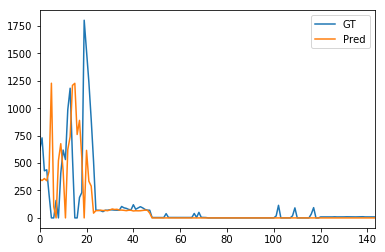

In [50]:
#pd.Series(train_appliance[0]).plot()
pd.Series(train_all_appliances[0]).plot(label='GT')
pd.Series(model.predict(test_agg)[0, :]).plot(label='Pred')
plt.legend()

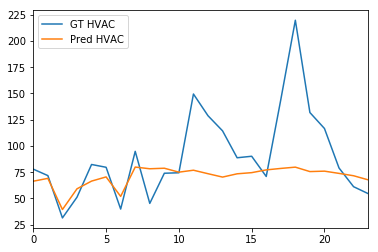

In [215]:
#pd.Series(test_agg[1, :]).plot(label='GT Agg')
#pd.Series(test_hvac[1, :]).plot(label='GT HVAC')
pd.Series(test_fridge[1, :]).plot(label='GT HVAC')


#pd.Series(test_fridge[1, :]).plot(label='GT Fridge')


#pd.Series(test_mw[1, :]).plot(label='GT MW')
#pd.Series(test_oven[1, :]).plot(label='GT Oven')







#pd.Series(model.predict(test_agg[1:2])[0, :24]).plot(label='Pred HVAC')
pd.Series(model.predict(test_agg[1:2])[0, 24:48]).plot(label='Pred HVAC')


#pd.Series(model.predict(test_agg[1:2])[0, 24:]).plot(label='Pred Fridge')




plt.legend()

In [216]:
print(np.mean(pred_fridge), np.mean(test_fridge))
np.mean(pred_hvac), np.mean(test_hvac), np.mean(test_agg)

83.6465 88.9532061557


(1034.436, 937.65674098776663, 1072.7840002015712)

In [217]:
(pd.DataFrame(test_fridge)-pd.DataFrame(pred_fridge)).abs().sum(axis=1).argmax()

137

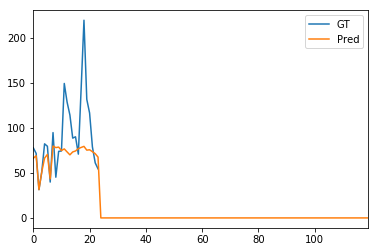

In [218]:
pd.Series(test_fridge[1, :]).plot(label='GT')
pd.Series(model.predict(test_agg_new[1:2])[0, 24:]).plot(label='Pred')


plt.legend()